# Models Comparison for TinyML

In [130]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [131]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

In [132]:
data = ['../data/X-intensity.pkl', '../data/X-all.pkl', '../data/X-10-25.pkl', '../data/X-1-2.pkl', '../data/X-25_50-50_25.pkl']
labels = ['../data/y-intensity.pkl', '../data/y-all.pkl', '../data/y-10-25.pkl', '../data/y-1-2.pkl', '../data/y-25_50-50_25.pkl']
choosenIndex = 0
tasks = ['intensity', 'all','10-25','1-2', '25-50']
with open(data[choosenIndex], 'rb') as f:
    X = pickle.load(f)

with open(labels[choosenIndex], 'rb') as f:
    y = pickle.load(f)

In [133]:
if choosenIndex == 1:
    X = X[165:-13]
    y = y[165:-13]
if choosenIndex == 2:
    X = X[146:-13]
    y = y[146:-13]
if choosenIndex == 3:
    X = X[101:-13]
    y = y[101:-13]

In [134]:
print(X.shape)

(3900, 60)


In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
uniques = np.unique(y)

In [136]:
print(X_test.shape)
print(y_test)

(780, 60)
[0 0 0 3 4 3 4 2 3 4 3 3 3 1 4 3 1 3 1 4 0 2 1 4 4 1 2 0 4 0 3 1 2 0 4 0 0
 2 3 0 0 1 1 3 3 2 2 4 2 4 4 4 2 0 1 3 0 2 0 2 4 1 0 4 4 3 4 1 4 2 2 1 2 2
 4 1 4 1 1 3 0 3 3 1 2 1 3 2 4 3 2 1 4 2 0 2 0 2 1 0 3 3 1 0 2 3 4 4 3 3 4
 0 3 1 4 4 2 3 4 0 3 3 3 2 2 1 2 3 3 0 4 3 1 4 3 4 0 4 3 3 1 0 3 3 3 0 2 2
 1 3 2 3 1 4 1 0 1 1 3 1 0 0 2 4 2 2 1 0 3 2 4 2 2 3 4 2 2 4 2 0 3 1 0 4 1
 0 1 1 1 4 1 3 4 3 3 3 1 2 2 0 2 1 1 1 2 4 1 2 0 3 3 2 1 4 2 4 1 3 1 1 0 1
 1 1 4 0 2 1 1 0 1 2 1 1 0 0 3 2 0 4 4 0 4 3 2 0 4 2 0 0 3 4 0 0 1 0 1 2 3
 1 0 4 2 2 4 4 3 2 3 1 0 3 0 1 0 1 0 2 3 0 4 0 2 1 4 1 4 4 4 1 1 2 3 4 3 3
 0 2 0 2 3 3 0 4 3 2 4 4 0 4 0 2 3 4 0 3 2 2 0 3 4 0 1 0 2 4 1 4 0 4 0 2 1
 4 2 4 0 0 3 4 3 1 3 3 0 0 3 2 1 0 1 0 1 3 2 2 1 1 1 3 0 0 2 1 2 3 3 0 1 4
 2 4 2 2 1 0 2 0 4 4 1 3 4 4 0 0 3 3 3 0 2 3 2 1 4 3 1 0 2 0 4 2 3 4 0 4 4
 2 3 3 4 4 4 2 4 3 3 0 3 3 2 4 4 3 0 2 0 3 2 4 3 4 1 1 0 0 0 0 2 1 0 0 1 0
 4 4 1 2 2 1 4 1 4 4 1 1 3 2 4 2 3 4 1 3 2 2 3 0 1 4 4 3 2 2 0 4 4 2 1 1 3
 1 0 4 0 3 4 4 

## Model Spotting

In [137]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [138]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR',  LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.5, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [139]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,78 0,03
LR - 0,48 0,02
CART - 0,78 0,03
SVC - 0,96 0,01
RF - 0,99 0,01


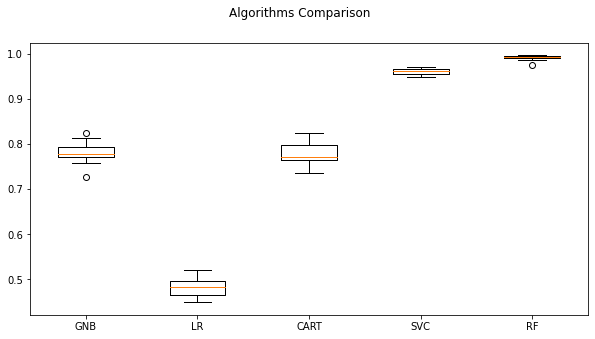

In [140]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Valutazione dei modelli sul Test Set

In [141]:

def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = uniques[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[choosenIndex]+ '/classificationReports'+ '/'+'classification_report' + model_name +  '.csv', index = False)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.71      0.68      0.70       156
           1       0.69      0.72      0.71       156
           2       0.99      0.97      0.98       156
           3       0.84      0.76      0.80       156
           4       0.79      0.87      0.83       156

    accuracy                           0.80       780
   macro avg       0.80      0.80      0.80       780
weighted avg       0.80      0.80      0.80       780

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.38      0.30      0.34       156
           1       0.38      0.51      0.43       156
           2       0.86      0.98      0.92       156
           3       0.18      0.08      0.11       156
           4       0.55      0.71      0.62       156

    accuracy                           0.52       780
   macro avg       0.47      0.52      0.48   

# Neural Network

In [144]:
def getNetwork():
    n = 50
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dense(np.unique(y).size * n, activation='relu'))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Cross-Validation NN

In [148]:
EPOCHS = 100
BATCH_SIZE = 10
num_folds = 10

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_43 (Dense)             (None, 250)               15250     
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 1255      
Total params: 20,165
Trainable params: 20,165
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
281/281 [==============================] - 0s 519us/step - loss: 1.6089 - accuracy: 0.2176
Epoch 2/100
281/281 [==============================] - 0s 557us/step - loss: 1.5890 - accuracy: 0.3020
Epoch 3/100
281/281 [==============================] - 0s 531us/step - loss: 1.5633 - accuracy: 0.3590
Epoch 4/100
281/281 [==============================] - 0s 511us/step -

281/281 [==============================] - 0s 521us/step - loss: 0.2690 - accuracy: 0.9163
Epoch 73/100
281/281 [==============================] - 0s 509us/step - loss: 0.2620 - accuracy: 0.9149
Epoch 74/100
281/281 [==============================] - 0s 531us/step - loss: 0.2597 - accuracy: 0.9149
Epoch 75/100
281/281 [==============================] - 0s 517us/step - loss: 0.2541 - accuracy: 0.9149
Epoch 76/100
281/281 [==============================] - 0s 501us/step - loss: 0.2513 - accuracy: 0.9170
Epoch 77/100
281/281 [==============================] - 0s 523us/step - loss: 0.2468 - accuracy: 0.9224
Epoch 78/100
281/281 [==============================] - 0s 547us/step - loss: 0.2431 - accuracy: 0.9241
Epoch 79/100
281/281 [==============================] - 0s 556us/step - loss: 0.2382 - accuracy: 0.9241
Epoch 80/100
281/281 [==============================] - 0s 507us/step - loss: 0.2355 - accuracy: 0.9266
Epoch 81/100
281/281 [==============================] - 0s 513us/step - loss:

281/281 [==============================] - 0s 605us/step - loss: 0.5933 - accuracy: 0.8027
Epoch 44/100
281/281 [==============================] - 0s 617us/step - loss: 0.5830 - accuracy: 0.8073
Epoch 45/100
281/281 [==============================] - 0s 600us/step - loss: 0.5739 - accuracy: 0.8141
Epoch 46/100
281/281 [==============================] - 0s 598us/step - loss: 0.5647 - accuracy: 0.8180
Epoch 47/100
281/281 [==============================] - 0s 590us/step - loss: 0.5580 - accuracy: 0.8234
Epoch 48/100
281/281 [==============================] - 0s 564us/step - loss: 0.5454 - accuracy: 0.8152
Epoch 49/100
281/281 [==============================] - 0s 568us/step - loss: 0.5382 - accuracy: 0.8291
Epoch 50/100
281/281 [==============================] - 0s 534us/step - loss: 0.5294 - accuracy: 0.8298
Epoch 51/100
281/281 [==============================] - 0s 643us/step - loss: 0.5231 - accuracy: 0.8344
Epoch 52/100
281/281 [==============================] - 0s 563us/step - loss:

281/281 [==============================] - 0s 539us/step - loss: 0.9584 - accuracy: 0.6941
Epoch 15/100
281/281 [==============================] - 0s 487us/step - loss: 0.9289 - accuracy: 0.7058
Epoch 16/100
281/281 [==============================] - 0s 519us/step - loss: 0.8990 - accuracy: 0.7169
Epoch 17/100
281/281 [==============================] - 0s 474us/step - loss: 0.8747 - accuracy: 0.7390
Epoch 18/100
281/281 [==============================] - 0s 534us/step - loss: 0.8510 - accuracy: 0.7407
Epoch 19/100
281/281 [==============================] - 0s 558us/step - loss: 0.8279 - accuracy: 0.7379
Epoch 20/100
281/281 [==============================] - 0s 564us/step - loss: 0.8067 - accuracy: 0.7411
Epoch 21/100
281/281 [==============================] - 0s 551us/step - loss: 0.7882 - accuracy: 0.7493
Epoch 22/100
281/281 [==============================] - 0s 518us/step - loss: 0.7692 - accuracy: 0.7582
Epoch 23/100
281/281 [==============================] - 0s 531us/step - loss:

281/281 [==============================] - 0s 474us/step - loss: 0.2595 - accuracy: 0.9199
Epoch 93/100
281/281 [==============================] - 0s 479us/step - loss: 0.2563 - accuracy: 0.9252
Epoch 94/100
281/281 [==============================] - 0s 484us/step - loss: 0.2533 - accuracy: 0.9241
Epoch 95/100
281/281 [==============================] - 0s 467us/step - loss: 0.2496 - accuracy: 0.9249
Epoch 96/100
281/281 [==============================] - 0s 475us/step - loss: 0.2467 - accuracy: 0.9249
Epoch 97/100
281/281 [==============================] - 0s 472us/step - loss: 0.2457 - accuracy: 0.9231
Epoch 98/100
281/281 [==============================] - 0s 462us/step - loss: 0.2422 - accuracy: 0.9259
Epoch 99/100
281/281 [==============================] - 0s 480us/step - loss: 0.2402 - accuracy: 0.9274
Epoch 100/100
281/281 [==============================] - 0s 472us/step - loss: 0.2362 - accuracy: 0.9284
Model: "Sequential-NN"
_____________________________________________________

281/281 [==============================] - 0s 568us/step - loss: 0.2624 - accuracy: 0.9177
Epoch 64/100
281/281 [==============================] - 0s 471us/step - loss: 0.2600 - accuracy: 0.9167
Epoch 65/100
281/281 [==============================] - 0s 460us/step - loss: 0.2543 - accuracy: 0.9192
Epoch 66/100
281/281 [==============================] - 0s 463us/step - loss: 0.2506 - accuracy: 0.9245
Epoch 67/100
281/281 [==============================] - 0s 468us/step - loss: 0.2468 - accuracy: 0.9209
Epoch 68/100
281/281 [==============================] - 0s 484us/step - loss: 0.2417 - accuracy: 0.9238
Epoch 69/100
281/281 [==============================] - 0s 466us/step - loss: 0.2386 - accuracy: 0.9249
Epoch 70/100
281/281 [==============================] - 0s 468us/step - loss: 0.2353 - accuracy: 0.9270
Epoch 71/100
281/281 [==============================] - 0s 485us/step - loss: 0.2300 - accuracy: 0.9277
Epoch 72/100
281/281 [==============================] - 0s 462us/step - loss:

281/281 [==============================] - 0s 515us/step - loss: 0.6529 - accuracy: 0.7877
Epoch 35/100
281/281 [==============================] - 0s 474us/step - loss: 0.6386 - accuracy: 0.7959
Epoch 36/100
281/281 [==============================] - 0s 481us/step - loss: 0.6239 - accuracy: 0.8020
Epoch 37/100
281/281 [==============================] - 0s 474us/step - loss: 0.6115 - accuracy: 0.8070
Epoch 38/100
281/281 [==============================] - 0s 491us/step - loss: 0.5990 - accuracy: 0.8116
Epoch 39/100
281/281 [==============================] - 0s 471us/step - loss: 0.5883 - accuracy: 0.8180
Epoch 40/100
281/281 [==============================] - 0s 464us/step - loss: 0.5771 - accuracy: 0.8162
Epoch 41/100
281/281 [==============================] - 0s 459us/step - loss: 0.5641 - accuracy: 0.8248
Epoch 42/100
281/281 [==============================] - 0s 460us/step - loss: 0.5530 - accuracy: 0.8291
Epoch 43/100
281/281 [==============================] - 0s 495us/step - loss:

281/281 [==============================] - 0s 475us/step - loss: 1.4308 - accuracy: 0.4491
Epoch 6/100
281/281 [==============================] - 0s 494us/step - loss: 1.3529 - accuracy: 0.4950
Epoch 7/100
281/281 [==============================] - 0s 487us/step - loss: 1.2779 - accuracy: 0.5281
Epoch 8/100
281/281 [==============================] - 0s 500us/step - loss: 1.2135 - accuracy: 0.5467
Epoch 9/100
281/281 [==============================] - 0s 525us/step - loss: 1.1613 - accuracy: 0.5698
Epoch 10/100
281/281 [==============================] - 0s 505us/step - loss: 1.1179 - accuracy: 0.5801
Epoch 11/100
281/281 [==============================] - 0s 494us/step - loss: 1.0819 - accuracy: 0.5976
Epoch 12/100
281/281 [==============================] - 0s 516us/step - loss: 1.0485 - accuracy: 0.6022
Epoch 13/100
281/281 [==============================] - 0s 468us/step - loss: 1.0191 - accuracy: 0.6129
Epoch 14/100
281/281 [==============================] - 0s 466us/step - loss: 0.9

Epoch 84/100
281/281 [==============================] - 0s 484us/step - loss: 0.2135 - accuracy: 0.9241
Epoch 85/100
281/281 [==============================] - 0s 483us/step - loss: 0.2104 - accuracy: 0.9298
Epoch 86/100
281/281 [==============================] - 0s 458us/step - loss: 0.2078 - accuracy: 0.9266
Epoch 87/100
281/281 [==============================] - 0s 485us/step - loss: 0.2029 - accuracy: 0.9323
Epoch 88/100
281/281 [==============================] - 0s 472us/step - loss: 0.2005 - accuracy: 0.9327
Epoch 89/100
281/281 [==============================] - 0s 462us/step - loss: 0.1970 - accuracy: 0.9380
Epoch 90/100
281/281 [==============================] - 0s 471us/step - loss: 0.1960 - accuracy: 0.9366
Epoch 91/100
281/281 [==============================] - 0s 474us/step - loss: 0.1923 - accuracy: 0.9323
Epoch 92/100
281/281 [==============================] - 0s 480us/step - loss: 0.1899 - accuracy: 0.9363
Epoch 93/100
281/281 [==============================] - 0s 492us

281/281 [==============================] - 0s 452us/step - loss: 0.4373 - accuracy: 0.8494
Epoch 56/100
281/281 [==============================] - 0s 485us/step - loss: 0.4290 - accuracy: 0.8558
Epoch 57/100
281/281 [==============================] - 0s 469us/step - loss: 0.4216 - accuracy: 0.8533
Epoch 58/100
281/281 [==============================] - 0s 455us/step - loss: 0.4139 - accuracy: 0.8554
Epoch 59/100
281/281 [==============================] - 0s 463us/step - loss: 0.4076 - accuracy: 0.8579
Epoch 60/100
281/281 [==============================] - 0s 457us/step - loss: 0.4013 - accuracy: 0.8625
Epoch 61/100
281/281 [==============================] - 0s 465us/step - loss: 0.3946 - accuracy: 0.8643
Epoch 62/100
281/281 [==============================] - 0s 462us/step - loss: 0.3886 - accuracy: 0.8672
Epoch 63/100
281/281 [==============================] - 0s 449us/step - loss: 0.3813 - accuracy: 0.8697
Epoch 64/100
281/281 [==============================] - 0s 465us/step - loss:

281/281 [==============================] - 0s 499us/step - loss: 0.6482 - accuracy: 0.8170
Epoch 27/100
281/281 [==============================] - 0s 484us/step - loss: 0.6276 - accuracy: 0.8198
Epoch 28/100
281/281 [==============================] - 0s 626us/step - loss: 0.6048 - accuracy: 0.8319
Epoch 29/100
281/281 [==============================] - 0s 507us/step - loss: 0.5858 - accuracy: 0.8362
Epoch 30/100
281/281 [==============================] - 0s 497us/step - loss: 0.5664 - accuracy: 0.8426
Epoch 31/100
281/281 [==============================] - 0s 521us/step - loss: 0.5477 - accuracy: 0.8458
Epoch 32/100
281/281 [==============================] - 0s 488us/step - loss: 0.5309 - accuracy: 0.8536
Epoch 33/100
281/281 [==============================] - 0s 503us/step - loss: 0.5137 - accuracy: 0.8558
Epoch 34/100
281/281 [==============================] - 0s 475us/step - loss: 0.4989 - accuracy: 0.8579
Epoch 35/100
281/281 [==============================] - 0s 491us/step - loss:

281/281 [==============================] - 0s 471us/step - loss: 1.5995 - accuracy: 0.2464
Epoch 2/100
281/281 [==============================] - 0s 491us/step - loss: 1.5685 - accuracy: 0.3725
Epoch 3/100
281/281 [==============================] - 0s 477us/step - loss: 1.5252 - accuracy: 0.4099
Epoch 4/100
281/281 [==============================] - 0s 503us/step - loss: 1.4619 - accuracy: 0.4366
Epoch 5/100
281/281 [==============================] - 0s 507us/step - loss: 1.3845 - accuracy: 0.4726
Epoch 6/100
281/281 [==============================] - 0s 506us/step - loss: 1.3065 - accuracy: 0.5071
Epoch 7/100
281/281 [==============================] - 0s 518us/step - loss: 1.2383 - accuracy: 0.5477
Epoch 8/100
281/281 [==============================] - 0s 499us/step - loss: 1.1846 - accuracy: 0.5734
Epoch 9/100
281/281 [==============================] - 0s 461us/step - loss: 1.1412 - accuracy: 0.5969
Epoch 10/100
281/281 [==============================] - 0s 472us/step - loss: 1.1065 

Epoch 80/100
281/281 [==============================] - 0s 457us/step - loss: 0.2285 - accuracy: 0.9313
Epoch 81/100
281/281 [==============================] - 0s 460us/step - loss: 0.2226 - accuracy: 0.9363
Epoch 82/100
281/281 [==============================] - 0s 463us/step - loss: 0.2197 - accuracy: 0.9330
Epoch 83/100
281/281 [==============================] - 0s 484us/step - loss: 0.2146 - accuracy: 0.9373
Epoch 84/100
281/281 [==============================] - 0s 481us/step - loss: 0.2116 - accuracy: 0.9359
Epoch 85/100
281/281 [==============================] - 0s 461us/step - loss: 0.2082 - accuracy: 0.9377
Epoch 86/100
281/281 [==============================] - 0s 517us/step - loss: 0.2041 - accuracy: 0.9352
Epoch 87/100
281/281 [==============================] - 0s 474us/step - loss: 0.2007 - accuracy: 0.9377
Epoch 88/100
281/281 [==============================] - 0s 467us/step - loss: 0.1985 - accuracy: 0.9420
Epoch 89/100
281/281 [==============================] - 0s 460us

281/281 [==============================] - 0s 482us/step - loss: 0.4537 - accuracy: 0.8533
Epoch 52/100
281/281 [==============================] - 0s 526us/step - loss: 0.4437 - accuracy: 0.8657
Epoch 53/100
281/281 [==============================] - 0s 467us/step - loss: 0.4338 - accuracy: 0.8647
Epoch 54/100
281/281 [==============================] - 0s 485us/step - loss: 0.4273 - accuracy: 0.8686
Epoch 55/100
281/281 [==============================] - 0s 487us/step - loss: 0.4163 - accuracy: 0.8714
Epoch 56/100
281/281 [==============================] - 0s 464us/step - loss: 0.4077 - accuracy: 0.8732
Epoch 57/100
281/281 [==============================] - 0s 474us/step - loss: 0.3988 - accuracy: 0.8782
Epoch 58/100
281/281 [==============================] - 0s 499us/step - loss: 0.3916 - accuracy: 0.8818
Epoch 59/100
281/281 [==============================] - 0s 532us/step - loss: 0.3836 - accuracy: 0.8807
Epoch 60/100
281/281 [==============================] - 0s 595us/step - loss:

# Train and Test

In [145]:
EPOCHS = 100
BATCH_SIZE = 10
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
report = classification_report(y_test, pred)
classification_report_csv(report, "NN")
print(report)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_40 (Dense)             (None, 250)               15250     
_________________________________________________________________
dense_41 (Dense)             (None, 5)                 1255      
Total params: 20,165
Trainable params: 20,165
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
234/234 [==============================] - 0s 782us/step - loss: 1.6025 - accuracy: 0.2491 - val_loss: 1.5986 - val_accuracy: 0.2205
Epoch 2/100
234/234 [==============================] - 0s 609us/step - loss: 1.5777 - accuracy: 0.3355 - val_loss: 1.5687 - val_accuracy: 0.2859
Epoch 3/100
234/234 [==============================] - 0s 602us/step - loss: 1.5457 - acc

234/234 [==============================] - 0s 603us/step - loss: 0.4583 - accuracy: 0.8654 - val_loss: 0.4952 - val_accuracy: 0.8500
Epoch 53/100
234/234 [==============================] - 0s 610us/step - loss: 0.4478 - accuracy: 0.8667 - val_loss: 0.4827 - val_accuracy: 0.8590
Epoch 54/100
234/234 [==============================] - 0s 601us/step - loss: 0.4344 - accuracy: 0.8714 - val_loss: 0.4841 - val_accuracy: 0.8397
Epoch 55/100
234/234 [==============================] - 0s 604us/step - loss: 0.4259 - accuracy: 0.8709 - val_loss: 0.4696 - val_accuracy: 0.8564
Epoch 56/100
234/234 [==============================] - 0s 585us/step - loss: 0.4192 - accuracy: 0.8761 - val_loss: 0.4617 - val_accuracy: 0.8603
Epoch 57/100
234/234 [==============================] - 0s 615us/step - loss: 0.4075 - accuracy: 0.8812 - val_loss: 0.4613 - val_accuracy: 0.8615
Epoch 58/100
234/234 [==============================] - 0s 644us/step - loss: 0.3974 - accuracy: 0.8863 - val_loss: 0.4323 - val_accuracy

# Export Models in C code

In [ ]:
# Neural network with TinyMLGen
with open(tasks[choosenIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[choosenIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    with open(path, 'w') as f:
        f.write(port(model, optimize=False))

# Valutazione Inferance Rate medio (Intensità)

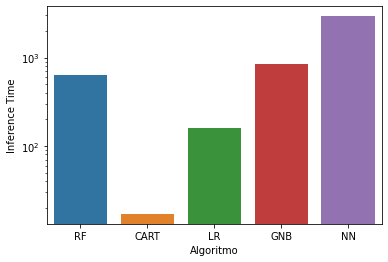

In [146]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

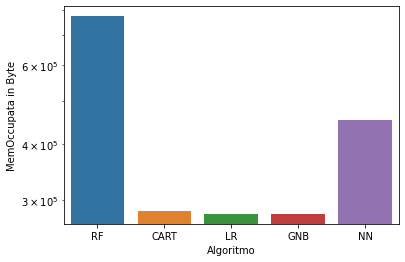

In [147]:
csv = read_csv("MemOccupationReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata'])
g.set_yscale('log')
plt.ylabel("MemOccupata in Byte")
plt.show()
# SVC in overflow